In [1]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras import optimizers
import numpy as np
from glob import glob
from pathlib import Path
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import load_model

2024-04-05 12:18:19.869386: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-05 12:18:19.897418: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-05 12:18:19.897446: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-05 12:18:19.898160: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-05 12:18:19.902974: I tensorflow/core/platform/cpu_feature_guar

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    print(e)


1 Physical GPUs, 1 Logical GPUs


2024-04-05 12:18:21.280576: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-05 12:18:21.309260: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-05 12:18:21.309438: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [3]:
train_path = 'FNNPK'

In [4]:
IMAGE_SIZE = [224, 224]

In [5]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_path,
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset='training'
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    train_path,
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=344,
    validation_split=0.2,
    subset='validation'
)

Found 208 files belonging to 4 classes.
Using 167 files for training.
Found 208 files belonging to 4 classes.
Using 41 files for validation.


In [6]:
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top= False)

vgg.trainable = False

In [7]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = vgg(image_batch)
print(feature_batch.shape)

2024-04-05 12:18:22.961461: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-04-05 12:18:24.943690: W external/local_tsl/tsl/framework/bfc_allocator.cc:366] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.


(32, 7, 7, 512)


In [8]:
folders = glob('FNNPK/*')
print(len(folders))

4


In [9]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
prediction_layer = tf.keras.layers.Dense(len(folders), activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 4)


In [10]:
factor = 0.2
height_factor = 0.3
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal_and_vertical'),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomHeight(factor, interpolation='bilinear', seed=42),
  tf.keras.layers.RandomWidth(factor, interpolation='nearest', seed=42),
  tf.keras.layers.RandomBrightness(factor, value_range=(40, 90), seed=42)
])

inputs = vgg.input
x = data_augmentation(inputs)
x = preprocess_input(x)
x = vgg(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = Flatten()(x)
outputs = prediction_layer(x)
model = Model(inputs=inputs, outputs=outputs)
print(model.output.shape)
model.summary()

(None, 4)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, None, None, 3)     0         
                                                                 
 tf.__operators__.getitem (  (None, None, None, 3)     0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, None, None, 3)     0         
 )                                                               
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)           

In [11]:
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer = 'adam',
  metrics=['accuracy']
)

In [12]:
r = model.fit(
  train_dataset,
  validation_data=test_dataset,
  epochs=50
)

Epoch 1/50
1/6 [====>.........................] - ETA: 1:00 - loss: 2.8477 - accuracy: 0.2812

2024-04-05 12:18:52.653460: I external/local_xla/xla/service/service.cc:168] XLA service 0x709684c7aa50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-05 12:18:52.653483: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2024-04-05 12:18:52.657486: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1712299732.730426   10876 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


4/6 [===================>..........] - ETA: 12s - loss: 2.5044 - accuracy: 0.3281

2024-04-05 12:19:13.274077: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.34GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-04-05 12:19:14.546509: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.34GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


6/6 [==============================] - 56s 9s/step - loss: 2.3139 - accuracy: 0.3293 - val_loss: 1.9919 - val_accuracy: 0.4634
Epoch 2/50
1/6 [====>.........................] - ETA: 17s - loss: 1.3838 - accuracy: 0.5625

2024-04-05 12:19:41.169622: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.41GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-04-05 12:19:42.489610: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.41GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


6/6 [==============================] - 37s 7s/step - loss: 1.5307 - accuracy: 0.4850 - val_loss: 1.7051 - val_accuracy: 0.5366
Epoch 3/50
6/6 [==============================] - 31s 5s/step - loss: 1.6271 - accuracy: 0.4251 - val_loss: 1.5735 - val_accuracy: 0.6098
Epoch 4/50
6/6 [==============================] - 27s 4s/step - loss: 1.4844 - accuracy: 0.5150 - val_loss: 1.3090 - val_accuracy: 0.6585
Epoch 5/50
6/6 [==============================] - 25s 4s/step - loss: 1.5335 - accuracy: 0.4790 - val_loss: 1.2484 - val_accuracy: 0.6341
Epoch 6/50
6/6 [==============================] - 13s 1s/step - loss: 1.4558 - accuracy: 0.5150 - val_loss: 1.3063 - val_accuracy: 0.6829
Epoch 7/50
1/6 [====>.........................] - ETA: 2s - loss: 1.1099 - accuracy: 0.4688

2024-04-05 12:21:50.126990: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.41GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-04-05 12:21:51.457882: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.41GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


6/6 [==============================] - 25s 5s/step - loss: 1.2029 - accuracy: 0.5868 - val_loss: 1.1305 - val_accuracy: 0.6829
Epoch 8/50
1/6 [====>.........................] - ETA: 2s - loss: 1.0470 - accuracy: 0.5625

2024-04-05 12:22:15.182109: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.34GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-04-05 12:22:16.481580: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.34GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


6/6 [==============================] - 13s 2s/step - loss: 0.9956 - accuracy: 0.5988 - val_loss: 1.1324 - val_accuracy: 0.7317
Epoch 9/50


2024-04-05 12:22:27.705827: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.48GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-04-05 12:22:29.055703: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.48GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


6/6 [==============================] - 18s 3s/step - loss: 1.0479 - accuracy: 0.5629 - val_loss: 1.1181 - val_accuracy: 0.7561
Epoch 10/50
6/6 [==============================] - 19s 4s/step - loss: 1.0504 - accuracy: 0.5988 - val_loss: 1.0503 - val_accuracy: 0.7561
Epoch 11/50
6/6 [==============================] - 16s 3s/step - loss: 0.9502 - accuracy: 0.6347 - val_loss: 0.9408 - val_accuracy: 0.7561
Epoch 12/50
6/6 [==============================] - 14s 2s/step - loss: 0.8922 - accuracy: 0.6467 - val_loss: 0.9385 - val_accuracy: 0.7805
Epoch 13/50
6/6 [==============================] - 27s 4s/step - loss: 0.8930 - accuracy: 0.6647 - val_loss: 0.9517 - val_accuracy: 0.7805
Epoch 14/50
6/6 [==============================] - 5s 572ms/step - loss: 0.7948 - accuracy: 0.7126 - val_loss: 1.0126 - val_accuracy: 0.7805
Epoch 15/50
6/6 [==============================] - 5s 836ms/step - loss: 0.7963 - accuracy: 0.6946 - val_loss: 0.9744 - val_accuracy: 0.7805
Epoch 16/50
6/6 [==================

In [13]:
model.save('Deficiency_Model.h5')

/home/geneviptopneo/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


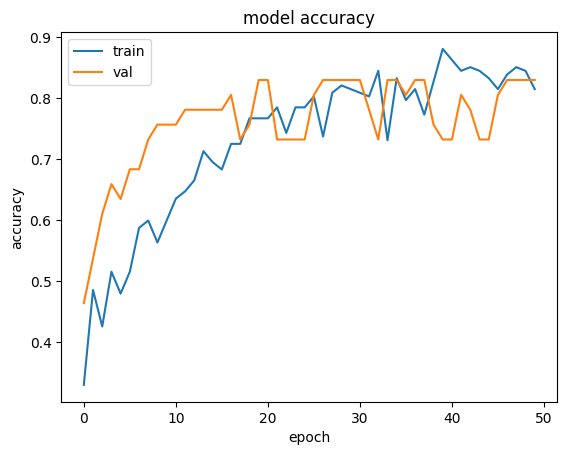

In [14]:
plt.plot(r.history['accuracy'])
plt.plot(r.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [16]:

train_dataset.class_names

['-K', '-N', '-P', 'FN']